# ML-IMC

In [1]:
using Dates
using Plots
using Statistics
using LinearAlgebra
using Distributed

if nworkers() == 1
    BLAS.set_num_threads(1)
    addprocs(4)
end

@everywhere begin
    include("src/distances.jl")
    include("src/readLJ.jl")
    include("src/ML-IMC.jl");
end

## 1. The first simulation

## 1.1. Input data 

In [297]:
bins, rdfref, histref = readRDF("rdf-mean-p40.dat");
parameters = readinput("LJML-init.in");

In [2]:
xyz = readXYZ("mctraj-p001.xyz")
conf = xyz[end]

parameters = readinput("LJML-init.in")

model = Dense(length(histref), 1, tanh, bias=true);

Reading mctraj-p001.xyz with 6012 lines...
Found 6 frames with 1000 atoms each...
Success! Closing the file...


## 1.2. Running the simulation

In [3]:
function main(conf, parameters, model)    
    # Start the timer
    startTime = Dates.now()
    println("Running MC simulation on $(nworkers()) rank(s)...\n")
    println("Total number of steps: $(parameters.steps * nworkers() / 1E6)M")
    println("Starting at: ", startTime)
    
    # Prepare inputs
    input = conf, parameters, model
    inputs = [input for worker in workers()]
    
    # Run the simulation in parallel
    outputs = pmap(mcrun!, inputs)
    
    # Stop the timer
    stopTime = Dates.now()
    wallTime = Dates.canonicalize(stopTime - startTime)
    println("Stopping at: ", stopTime, "\n")
    println("Walltime: ", wallTime)
    
    return(outputs)
end;

In [5]:
outputs = main(conf, parameters, model);

Running MC simulation on 4 rank(s)...

Total number of steps: 40.0M
Starting at: 2022-03-24T23:20:41.434
      From worker 5:	Acceptance ratio = 0.7598414
      From worker 2:	Acceptance ratio = 0.7600581
      From worker 3:	Acceptance ratio = 0.7595518
      From worker 4:	Acceptance ratio = 0.7599369
Stopping at: 2022-03-24T23:29:36.417

Walltime: 8 minutes, 54 seconds, 983 milliseconds


# 1.3 Analyzing

In [298]:
histNN = mean([output[1] for output in outputs]);

In [299]:
energies = mean([output[2] for output in outputs]);

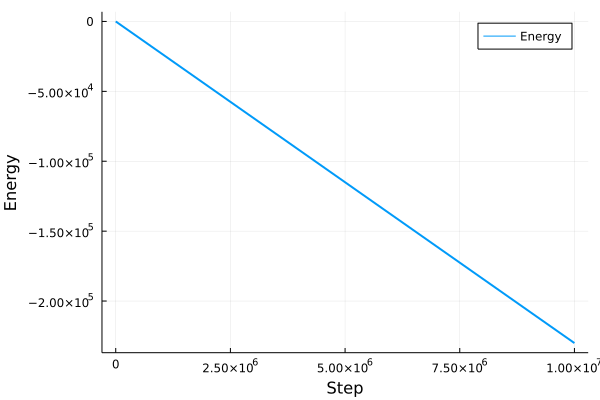

In [300]:
slicing = Int(1E4)
steps = 0:parameters.outfreq:parameters.steps
plot(steps[1:slicing:end], energies[1:slicing:end], lw=2, labels="Energy")
xlabel!("Step")
ylabel!("Energy")

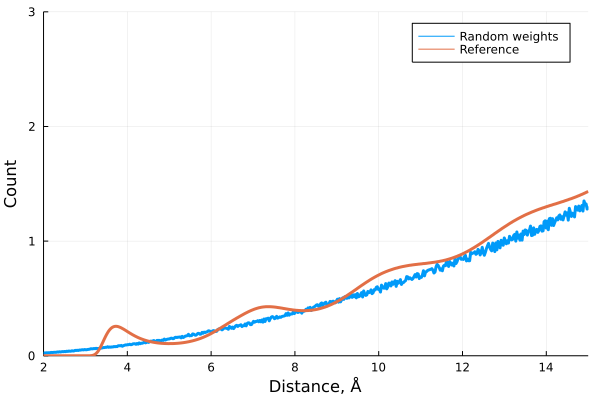

In [301]:
plot(bins, histNN, xlim = (2, 15), ylim = (0, 3), linewidth=3, labels="Random weights")
plot!(bins, histref./500, xlim = (2, 15), ylim = (0, 3), linewidth=3, labels="Reference")
xlabel!("Distance, Å")
ylabel!("Count")

# 1.4 Setting up the training

Now I'm looking at the following:

$$ \frac{\partial \langle S_i \rangle}{\partial \lambda_j} =
- \beta \Big(
\langle \frac{\partial H}{\partial \lambda_j} S_i \rangle
- \langle \frac{\partial H}{\partial \lambda_j} \rangle  \langle S_i \rangle 
\Big)
$$

### Cross terms (the first terms):

In [203]:
crossWeights = mean([output[3] for output in outputs])

600×600 Matrix{Float32}:
 0.0  0.0  0.0          0.0          0.0         …  0.0          0.0
 0.0  0.0  0.0          0.0          0.0            0.0          0.0
 0.0  0.0  3.82196f-5   0.0          0.0            3.54255f-5   9.43963f-5
 0.0  0.0  0.0          6.79021f-5   0.0            0.000108173  6.03917f-5
 0.0  0.0  0.0          0.0          4.20001f-5     7.90561f-5   5.37207f-5
 0.0  0.0  0.0          0.0          0.0         …  3.98665f-5   7.69656f-5
 0.0  0.0  0.0          0.0          0.0            7.9815f-5    6.26138f-5
 0.0  0.0  0.0          0.0          0.0            0.000141806  0.00016425
 0.0  0.0  0.0          0.0          0.0            0.000166596  0.000117389
 0.0  0.0  0.0          0.0          0.0            0.000111838  8.00603f-5
 0.0  0.0  0.0          0.0          0.0         …  0.00031149   0.000371178
 0.0  0.0  0.0          0.0          0.0            0.000210871  0.000218521
 0.0  0.0  0.0          0.0          0.0            0.000282619  0.0003464

In [205]:
crossBiases = mean([output[4] for output in outputs])

600-element Vector{Float32}:
 0.0
 0.0
 3.8219638f-5
 6.790206f-5
 4.200006f-5
 7.1298105f-5
 3.814607f-5
 6.693382f-5
 0.00010293968
 0.0001085389
 0.00019592559
 0.00020030048
 0.0001969717
 ⋮
 0.42612946
 0.43063226
 0.43434286
 0.43262416
 0.43754512
 0.43338352
 0.4398052
 0.42872402
 0.43540224
 0.44247115
 0.45240462
 0.44365436

### Products (the second terms):

In [213]:
dHdw, dHdb = gradient(neuralenergy, histNN, model)[2];

In [214]:
productWeights = Float32.(histNN * dHdw)

600×600 Matrix{Float32}:
 0.0  0.0  0.0         0.0         0.0         …  0.0          0.0
 0.0  0.0  0.0         0.0         0.0            0.0          0.0
 0.0  0.0  1.60821f-9  2.14427f-9  2.68034f-9     2.74392f-5   2.79522f-5
 0.0  0.0  2.14427f-9  2.85903f-9  3.57379f-9     3.65856f-5   3.72696f-5
 0.0  0.0  2.68034f-9  3.57379f-9  4.46724f-9     4.5732f-5    4.65871f-5
 0.0  0.0  4.28855f-9  5.71807f-9  7.14758f-9  …  7.31712f-5   7.45393f-5
 0.0  0.0  1.60821f-9  2.14427f-9  2.68034f-9     2.74392f-5   2.79522f-5
 0.0  0.0  3.21641f-9  4.28855f-9  5.36069f-9     5.48784f-5   5.59045f-5
 0.0  0.0  6.96889f-9  9.29186f-9  1.16148f-8     0.000118903  0.000121126
 0.0  0.0  6.96889f-9  9.29186f-9  1.16148f-8     0.000118903  0.000121126
 0.0  0.0  9.11317f-9  1.21509f-8  1.51886f-8  …  0.000155489  0.000158396
 0.0  0.0  1.01853f-8  1.35804f-8  1.69755f-8     0.000173782  0.000177031
 0.0  0.0  1.12574f-8  1.50099f-8  1.87624f-8     0.000192074  0.000195666
 ⋮                    

In [215]:
productBiases = Float32.(histNN .* dHdb)

600-element Vector{Float32}:
 0.0
 0.0
 2.1442747f-5
 2.859033f-5
 3.5737914f-5
 5.718066f-5
 2.1442747f-5
 4.2885495f-5
 9.291858f-5
 9.291858f-5
 0.00012150891
 0.00013580408
 0.00015009924
 ⋮
 0.36702123
 0.36318296
 0.37332538
 0.36141038
 0.36813626
 0.37481922
 0.3608886
 0.3860767
 0.3789005
 0.37852883
 0.36585617
 0.3726964

The terms look quite similar.

### Histogram gradients:

In [216]:
dSdw = -Float32(parameters.β) .* (crossWeights - productWeights)

600×600 Matrix{Float32}:
 -0.0  -0.0  -0.0          -0.0          …  -0.0          -0.0
 -0.0  -0.0  -0.0          -0.0             -0.0          -0.0
 -0.0  -0.0  -4.8385f-5     2.71471f-9      -1.01109f-5   -8.41199f-5
 -0.0  -0.0   2.71471f-9   -8.59621f-5      -9.06315f-5   -2.92731f-5
 -0.0  -0.0   3.39338f-9    4.52451f-9      -4.21891f-5   -9.03135f-6
 -0.0  -0.0   5.42941f-9    7.23922f-9   …   4.21646f-5   -3.07177f-6
 -0.0  -0.0   2.03603f-9    2.71471f-9      -6.63091f-5   -4.38825f-5
 -0.0  -0.0   4.07206f-9    5.42941f-9      -0.000110052  -0.000137168
 -0.0  -0.0   8.82279f-9    1.17637f-8      -6.03803f-5    4.73136f-6
 -0.0  -0.0   8.82279f-9    1.17637f-8       8.94433f-6    5.19906f-5
 -0.0  -0.0   1.15375f-8    1.53833f-8   …  -0.000197501  -0.000269387
 -0.0  -0.0   1.28949f-8    1.71931f-8      -4.69558f-5   -5.25272f-5
 -0.0  -0.0   1.42522f-8    1.90029f-8      -0.000114632  -0.000190951
  ⋮                                      ⋱                
 -0.0  -0.0  -3.9

In [217]:
dSdb = -Float32(parameters.β) .* (crossBiases - productBiases)

600-element Vector{Float32}:
 -0.0
 -0.0
 -2.1239966f-5
 -4.976964f-5
 -7.928036f-6
 -1.7873042f-5
 -2.1146829f-5
 -3.0445784f-5
 -1.268697f-5
 -1.9775724f-5
 -9.421339f-5
 -8.165407f-5
 -5.9341717f-5
  ⋮
 -0.07483251
 -0.08539251
 -0.07724967
 -0.09015844
 -0.08787337
 -0.07414389
 -0.099910416
 -0.053992596
 -0.07153264
 -0.08095258
 -0.109572515
 -0.08983456

### Loss vector:

In [218]:
function loss(histNN, histref)
    loss = zeros(length(histNN))
    for i in 1:length(loss)
        loss[i] = (histNN[i] - histref[i])^2
    end
    return(sum(loss))
end;

In [219]:
L = loss(histNN, histref./500)

4.364387524354

In [220]:
function lossDerivative(histNN, histref)
    loss = zeros(length(histNN))
    for i in 1:length(loss)
        loss[i] = 2*(histNN[i] - histref[i])
    end
    return(loss)
end;

In [221]:
dL = lossDerivative(histNN, histref./500)

600-element Vector{Float64}:
  0.0
  0.0
  0.00015000000000000001
  0.0002
  0.00025
  0.0004000000000000001
  0.00015000000000000001
  0.00030000000000000003
  0.00065
  0.00065
  0.00085
  0.0009499999999999999
  0.00105
  ⋮
 -0.20929799999999998
 -0.2446079999999995
 -0.18032999999999966
 -0.271652
 -0.233282
 -0.19343600000000016
 -0.299118
 -0.13185800000000025
 -0.18986999999999998
 -0.2017380000000002
 -0.2987880000000005
 -0.2592500000000002

### Loss gradient:

In [72]:
dLdw = zeros(length(model.weight));

In [222]:
for i in 1:length(dLdw)
    dLdw[i] = 2 * dL[i] * sum(dSdw[i, :]) # take a column from dS/dw matrix
end

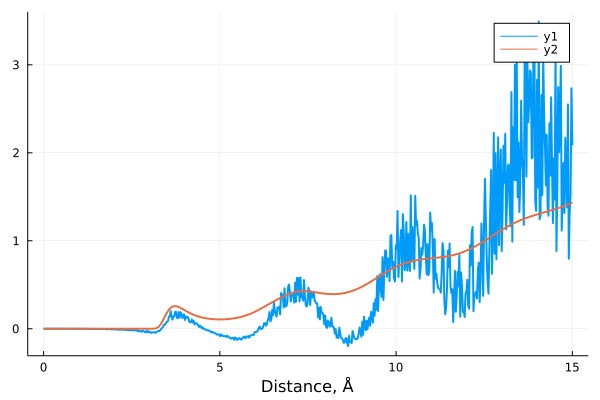

In [223]:
plot(bins, dLdw./10, lw=2)
plot!(bins, histref./500, lw=2)
xlabel!("Distance, Å")

I have the gradients now and they make sense I think, but they are very noisy.

In [224]:
dLdw

600-element Vector{Float64}:
  0.0
  0.0
 -2.1734719164669517e-6
 -6.3576884567737584e-6
 -1.7041058745235204e-6
 -5.163056030869485e-6
 -2.2096753120422365e-6
 -6.482468359172344e-6
 -1.0292300954461097e-5
 -1.0880476888269186e-5
 -5.720637366175651e-5
 -5.2049471437931054e-5
 -4.562368299812078e-5
  ⋮
 14.901367056747436
 18.85186570312496
 13.155078452911352
 21.700709201202393
 18.363053406356812
 13.79053963095094
 25.5021189743042
  7.9562453443374785
 13.322472087478637
 15.247698559066787
 27.340111850189256
 20.82857919311525

In [225]:
dLdb = sum(dL .* dSdb)

3.263458994972812

### The training!

In [226]:
L

4.364387524354

In [308]:
model.weight

1×600 Matrix{Float32}:
 -0.0595583  0.0599112  0.0959234  …  -0.0203293  -0.0782264  0.0546515

In [311]:
for weight in model.weight
    @printf("%12.3f", weight)
end

      -0.060       0.060       0.096       0.074       0.020      -0.058       0.041       0.023       0.009       0.044       0.026       0.028       0.059       0.085       0.008      -0.076      -0.011      -0.077       0.046       0.037       0.022       0.097       0.065      -0.002      -0.002      -0.095      -0.097      -0.067       0.078      -0.029      -0.058       0.056       0.035      -0.065       0.082       0.057      -0.087      -0.085      -0.001      -0.056       0.066       0.062      -0.099      -0.093      -0.090       0.041       0.085       0.031      -0.035      -0.044       0.017       0.001       0.037       0.081      -0.007      -0.068       0.088       0.033       0.034      -0.018       0.090       0.059      -0.014       0.031      -0.016       0.012      -0.039      -0.053      -0.061      -0.060      -0.007      -0.050      -0.003      -0.014       0.055       0.001       0.006       0.030       0.025      -0.046      -0.023      -0.066      -0.043    

In [228]:
model.bias

1-element Vector{Float32}:
 3.0228892f-10

In [280]:
Flux.Optimise.update!(model.weight, 0.001*dLdw')

1×600 Matrix{Float32}:
 0.0285078  -0.00195444  0.0703399  …  -0.0256754  0.0396013  -0.0152875

In [281]:
Flux.Optimise.update!(model.bias, 0.001*dLdb')

1-element Vector{Float32}:
 -0.0032634868

In [268]:
model.weight

1×600 Matrix{Float32}:
 0.0285078  -0.00195444  0.0703399  …  0.00481999  0.0942815  0.0263697

In [269]:
model.bias

1-element Vector{Float32}:
 0.0032634311

In [282]:
neuralenergy(histNN, model)

-0.9990111389542498

The model is trained! Now I need to run the simulation again.

# 2.1 The second simulation

In [283]:
xyz = readXYZ("mctraj-p001.xyz")
conf = xyz[end]

parameters = readinput("LJML-init.in")

Reading mctraj-p001.xyz with 6012 lines...
Found 6 frames with 1000 atoms each...
Success! Closing the file...


inputParms([36.405, 36.405, 36.405], 1.266025230073036, 0.75, 1000000, 100000, 0, 1000, 0.025, 600)

In [284]:
second_outputs = main(conf, parameters, model);

Running MC simulation on 4 rank(s)...

Total number of steps: 4.0M
Starting at: 2022-03-25T01:28:56.392
      From worker 5:	Acceptance ratio = 0.996777
      From worker 2:	Acceptance ratio = 0.996794
      From worker 3:	Acceptance ratio = 0.996728
      From worker 4:	Acceptance ratio = 0.996751
Stopping at: 2022-03-25T01:29:36.933

Walltime: 40 seconds, 541 milliseconds


In [285]:
histNN = mean([output[1] for output in second_outputs]);

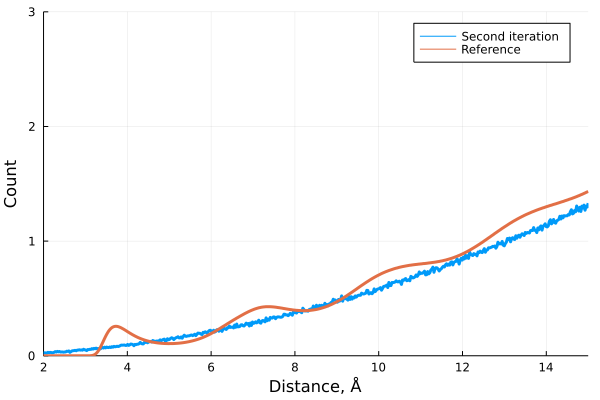

In [286]:
plot(bins, histNN, xlim = (2, 15), ylim = (0, 3), linewidth=3, labels="Second iteration")
plot!(bins, histref./500, xlim = (2, 15), ylim = (0, 3), linewidth=3, labels="Reference")
xlabel!("Distance, Å")
ylabel!("Count")

In [287]:
L2 = loss(histNN, histref./500)

4.349926469904001

Loss is smaller! I will take a bigger step.

In [288]:
crossWeights = mean([output[3] for output in second_outputs])

600×600 Matrix{Float32}:
 0.0  0.0  0.0         0.0  0.0  0.0  …  0.0         0.0         0.0
 0.0  0.0  0.0         0.0  0.0  0.0     0.0         0.0         0.0
 0.0  0.0  1.24839f-6  0.0  0.0  0.0     1.24839f-6  1.24839f-6  2.49679f-6
 0.0  0.0  0.0         0.0  0.0  0.0     0.0         0.0         0.0
 0.0  0.0  0.0         0.0  0.0  0.0     0.0         0.0         0.0
 0.0  0.0  0.0         0.0  0.0  0.0  …  0.0         0.0         0.0
 0.0  0.0  0.0         0.0  0.0  0.0     0.0         0.0         0.0
 0.0  0.0  0.0         0.0  0.0  0.0     6.6601f-8   6.6601f-8   6.6601f-8
 0.0  0.0  0.0         0.0  0.0  0.0     0.0         0.0         1.21246f-7
 0.0  0.0  0.0         0.0  0.0  0.0     7.0461f-9   2.81844f-8  0.0
 0.0  0.0  0.0         0.0  0.0  0.0  …  1.64418f-6  2.46626f-6  8.22088f-7
 0.0  0.0  0.0         0.0  0.0  0.0     0.0         0.0         0.0
 0.0  0.0  0.0         0.0  0.0  0.0     1.08468f-5  2.71171f-6  2.71171f-6
 ⋮                               ⋮    ⋱     

In [ ]:
crossBiases = mean([output[4] for output in second_outputs])

In [ ]:
dHdw, dHdb = gradient(neuralenergy, histNN, model)[2];

In [ ]:
productWeights = Float32.(histNN * dHdw)

In [ ]:
productBiases = Float32.(histNN .* dHdb)

In [ ]:
dSdw = -Float32(parameters.β) .* (crossWeights - productWeights)

In [ ]:
dSdb = -Float32(parameters.β) .* (crossBiases - productBiases)